# Very basic Auto-Encoder: get it more sophosticated and explore performance

We now make a more sophisticated algorithm to define the 'normal' sample in which the probability of the chars depend on the value of the other chars.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Generate Sequence Data

In [2]:
first_letters =  'ABCDEF'
second_numbers = '7890'
alternative_second_numbers = '1234'
last_letters = 'RSTUVWXYZ'

# returns a string of the following format: [4 letters A-F][1 digit 7-0][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    ## Observe the sophistication of these 'if'
    if str1[1] in 'ADF':
        str2 = random.choice(second_numbers)
    else:
        str2 = random.choice(alternative_second_numbers)
    ##
    if int(str2[0]) < 5:
        str3 = ''.join(random.choice('RSTU') for i in range(2))
    else:
        str3 = ''.join(random.choice('VWXYZ') for i in range(2))
    ## 
    if str1[2] in 'BCF':
        str4 = ''.join(random.choice('RSTUVW'))
    else:
        str4 = ''.join(random.choice('XYZ'))
    return str1+str2+str3+str4

In [3]:
[get_random_string() for i in range(20)]

['ACFD4RTW',
 'CEBD3USU',
 'ABAB1RTX',
 'EABC7XWR',
 'FEDA1UTZ',
 'CAEB7WYZ',
 'FDCA9ZZV',
 'FCBB1RTW',
 'BFFC8YWR',
 'BEDF2SRX',
 'CCEF2RUZ',
 'ECDA4TSZ',
 'CEEE2STZ',
 'BEFB3SRW',
 'CEEA2TSZ',
 'CAED9XXX',
 'FFCB7XZS',
 'CFFA0URW',
 'DAAD0RUX',
 'DEFC2USV']

In [4]:
# The guys thath wants to fake the data does not see the sophistication in the building
first_letters2 =  'ABCDEF'
second_numbers2 = '1234567890'
last_letters2 = 'RSTUVWXYZ'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_fake_string():
    str1 = ''.join(random.choice(first_letters2) for i in range(4))
    str2 = random.choice(second_numbers2)
    str3 = ''.join(random.choice(last_letters2) for i in range(3))
    return str1+str2+str3

In [6]:
#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

In [7]:
#print(list(enumerate(char_index)))

In [8]:
#char_to_int

In [9]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
def encode_sequence_list(seqs):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs


Using TensorFlow backend.
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/fra

In [12]:
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
random_sequences[:5]

['FECE2RTU', 'AEFD4TUV', 'DAEF8WXY', 'CAFB7ZZS', 'ABAB1RUY']

In [13]:
# Create 10k fake sequences
# There will never be 10k anomalies, this is a trick just to study how well recognizes fake events
fake_sequences = [get_fake_string() for i in range(10000)]
fake_sequences[:5]

['FBDE7VUT', 'BDEA7SRU', 'DBEA7XRX', 'EDDB8WUR', 'ECAF3XWU']

In [14]:
# add some anomalies to our list
random_sequences = random_sequences + fake_sequences
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)

### Prepare the Data and Build an Autoencoder

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
# Divide in train and test:
# Important: we do not use the fake events to train and test!
X_train = scaled_seqs[:20000]  
X_test = scaled_seqs[20000:25000]

In [16]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Parameters for the auto-encoder
input_dim = X_train.shape[1] # number of features (8 in this case)
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)

# Typical training features
nb_epoch = 30
batch_size = 128
learning_rate = 0.1

# We create the auto-encoder layer by layer:

# Create first layer that receives each scaled_seq
input_layer = Input(shape=(input_dim, ))

# Pass it to a first layer and encode
encoder = Dense(8, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
#encoder = Dense(10, activation="relu")(encoder)
encoder = Dense(4, activation='relu')(encoder)
# start decoder
#decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

# Physically create the auto-encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)



W1109 11:18:53.593024 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1109 11:18:53.608623 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 11:18:53.612103 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


### Fit the Model

In [18]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,   # <---- THIS IS THE *KEY* LINE THAT DEFINES THAT IS AN AUTOENCODER!
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

W1109 11:19:02.365255 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 11:19:03.170497 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1109 11:19:03.253874 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1109 11:19:03.458946 140392143037952 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1109 11:19:03.459553 140392143037952 deprecation

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 0s 14us/step - loss: 0.3069 - acc: 0.1178 - val_loss: 0.1876 - val_acc: 0.1098
Epoch 2/30
20000/20000 [==============================] - 1s 29us/step - loss: 0.1529 - acc: 0.2134 - val_loss: 0.1340 - val_acc: 0.3098
Epoch 3/30
20000/20000 [==============================] - 0s 14us/step - loss: 0.1213 - acc: 0.3206 - val_loss: 0.1140 - val_acc: 0.3090
Epoch 4/30
20000/20000 [==============================] - 0s 9us/step - loss: 0.1065 - acc: 0.3211 - val_loss: 0.1038 - val_acc: 0.3134
Epoch 5/30
20000/20000 [==============================] - 0s 9us/step - loss: 0.0987 - acc: 0.3321 - val_loss: 0.0975 - val_acc: 0.3234
Epoch 6/30
20000/20000 [==============================] - 0s 9us/step - loss: 0.0931 - acc: 0.3385 - val_loss: 0.0921 - val_acc: 0.3244
Epoch 7/30
20000/20000 [==============================] - 0s 9us/step - loss: 0.0864 - acc: 0.3386 - val_loss: 0.0832 - val_acc: 0.3

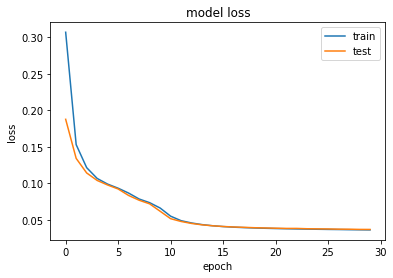

In [19]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [20]:
#autoencoder = load_model('model_seqs2.h5')
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.0359688007414341


### Calculate the Error Term

In [21]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that


MSE: 0.3132606172496768


### Lets return to the seqs_ds data set that holds all the sequences

In [22]:
#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
scaled_data = scaler.transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
# now add them to our data frame
# We have the mse for all, real and fake datapoints
seqs_ds['MSE'] = mse

## Let's compute some AUC curves

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

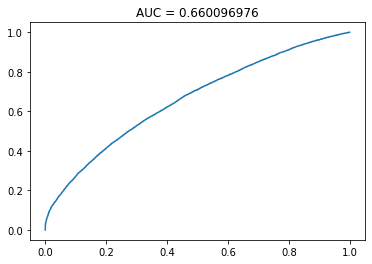

In [25]:
# We define the ytrue and yscore for the AUC
y_true = [0] * 25000 + [1] * 10000
y_scores = seqs_ds['MSE']
# And compute it
auc = roc_auc_score(y_true, y_scores)
fpr , tpr, _= roc_curve(y_true, y_scores)
plt.plot(fpr,tpr)
plt.title('AUC = '+str(auc))
plt.show()

# Home Work 

## Autoencoder : 8 > 8 > 4 > 8 > 8

 AUC = 0.63
 
 The very simple usual autoencoder

In [ ]:
# Create first layer that receives each scaled_seq
input_layer = Input(shape=(input_dim, ))

# Pass it to a first layer and encode
encoder = Dense(8, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(4, activation='relu')(encoder)
# start decoder
decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

# Physically create the auto-encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Autoencoder: 8 > 14 > 10 > 4 > 10 > 14 > 8

 AUC = 0.66
 
 We sophisticate the network making it wider at the beginning, so that it can better relate the char positions in the string

In [ ]:
# Create first layer that receives each scaled_seq
input_layer = Input(shape=(input_dim, ))


encoder = Dense(14, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(10, activation="relu")(encoder)
encoder = Dense(4, activation='relu')(encoder)
decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(14, activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

# Physically create the auto-encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Autoencoder : 8 > 14 > 10 > 8 > 10 > 14 > 8

 AUC ~ 0.73
 
 We do the same as before, but we make the latent space more sophisticated

In [ ]:
input_layer = Input(shape=(input_dim, ))

# Pass it to a first layer and encode
encoder = Dense(14, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(10, activation="relu")(encoder)
encoder = Dense(8, activation='relu')(encoder)
# start decoder
decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(14, activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)